In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import os

Matplotlib created a temporary cache directory at /tmp/matplotlib-1bfttnrv because the default path (/home/hyunsookim/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [4]:
def calcL1(real, virt):
    diff = np.subtract(real, virt)
    return np.sum(np.abs(diff), 0)
def calcL2(real, virt):
    diff = np.subtract(real, virt)
    return np.sum(np.power(diff, 2), 0)

def calcMAE(real, virt):
    return calcL1(real, virt)/len(real)


def calcMeanError(real, virt):
    return np.mean(np.abs(np.subtract(real, virt)), 0)

def printErrors(real, virt):
    print("L1 error:", calcL1(real, virt))
    print("MAE:", calcL1(real, virt)/len(real))
    
    print("L2 error:", calcL2(real, virt))
    print("MSE:", calcL2(real, virt)/len(real))
    
    # print(calcMeanError(real, virt))

In [39]:
# def plotTrajectory(traj):
#     n = traj.shape[1]-1
#     fig, axes = plt.subplots(1, n, figsize=(30, 5))

#     AXIS = ['X', 'Y', 'Z']
#     for i in range(n):
#         axes[i].plot(traj[:, i+1])  # Plot the i-th column (axis)
#         axes[i].set_title(f'Axis {AXIS[i]}')  # Title for the figure
#         axes[i].set_xlabel('Index')  # X-axis label (assuming index is the x-axis)
#         axes[i].set_ylabel('Value')  # Y-axis label
#         axes[i].grid(True)
#         if len(traj) < 100:
#             axes[i].set_xticks(np.arange(len(traj)))
#     plt.show()
    
def plotTrajectory(traj):
    n = 2
    fig, axes = plt.subplots(1, n, figsize=(30, 5))

    AXIS = ['X', 'Y', 'Z']
    for i in range(2):
        axes[i].plot(traj[:, i+1])  # Plot the i-th column (axis)
        axes[i].set_title(f'Axis {AXIS[i]}')  # Title for the figure
        axes[i].set_xlabel('Index')  # X-axis label (assuming index is the x-axis)
        axes[i].set_ylabel('Value')  # Y-axis label
        axes[i].grid(True)
        if len(traj) < 200:
            axes[i].set_xticks(np.arange(len(traj)))
    plt.show()
        

In [40]:
virtTraj = pd.read_csv("ball1_soft/ball1_soft_virtual_centroids_0.9_0.7_0.txt").to_numpy()
realTraj = pd.read_csv("ball1_hard/ball1_hard_centroids_transformed.txt").to_numpy()

virtTraj[:, 0] -= virtTraj[0, 0]
virtTraj[:, 0] *= 1000
realTraj[:, 0] -= realTraj[0, 0]


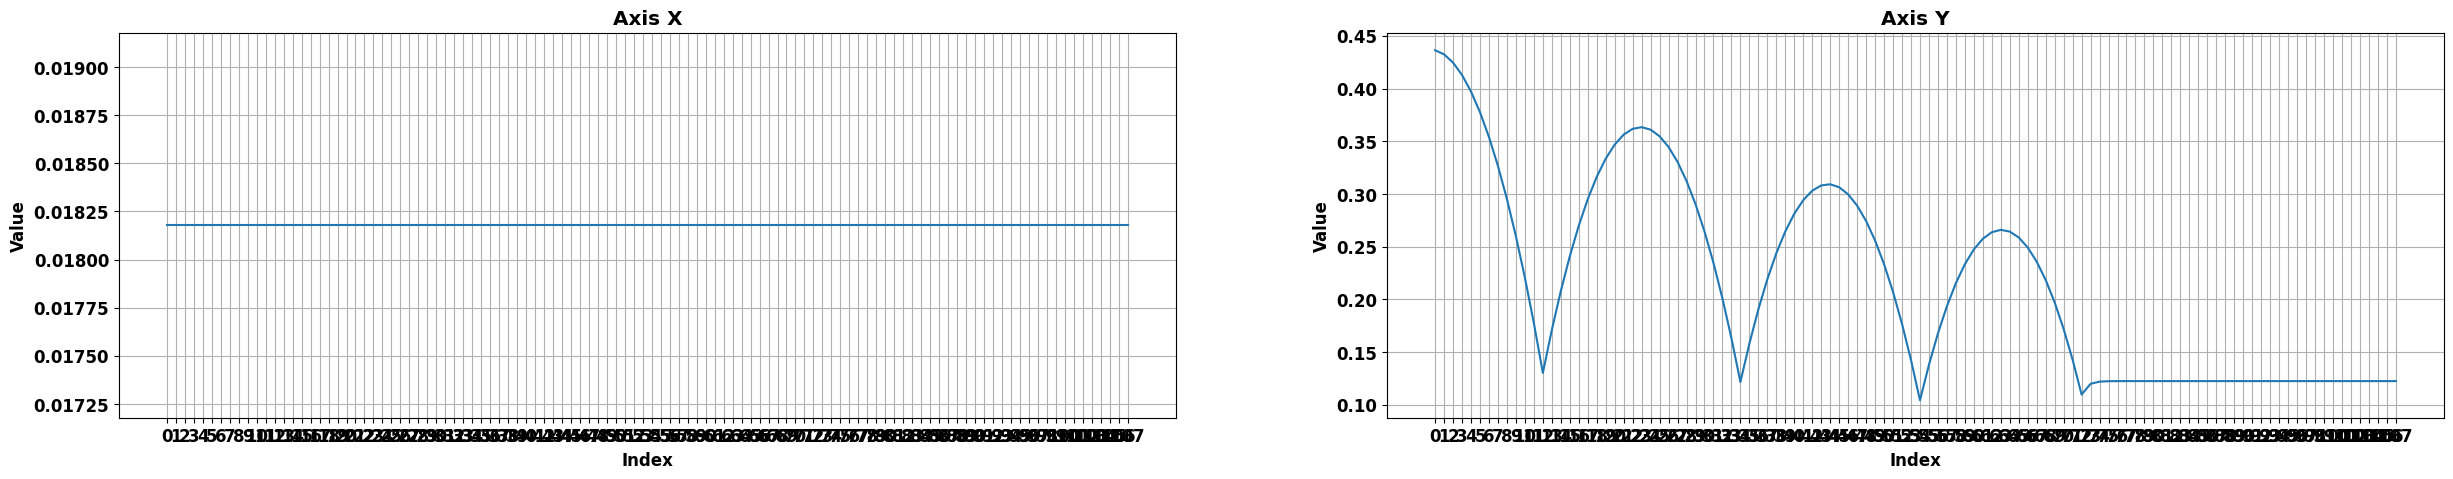

In [41]:
plotTrajectory(virtTraj[:])

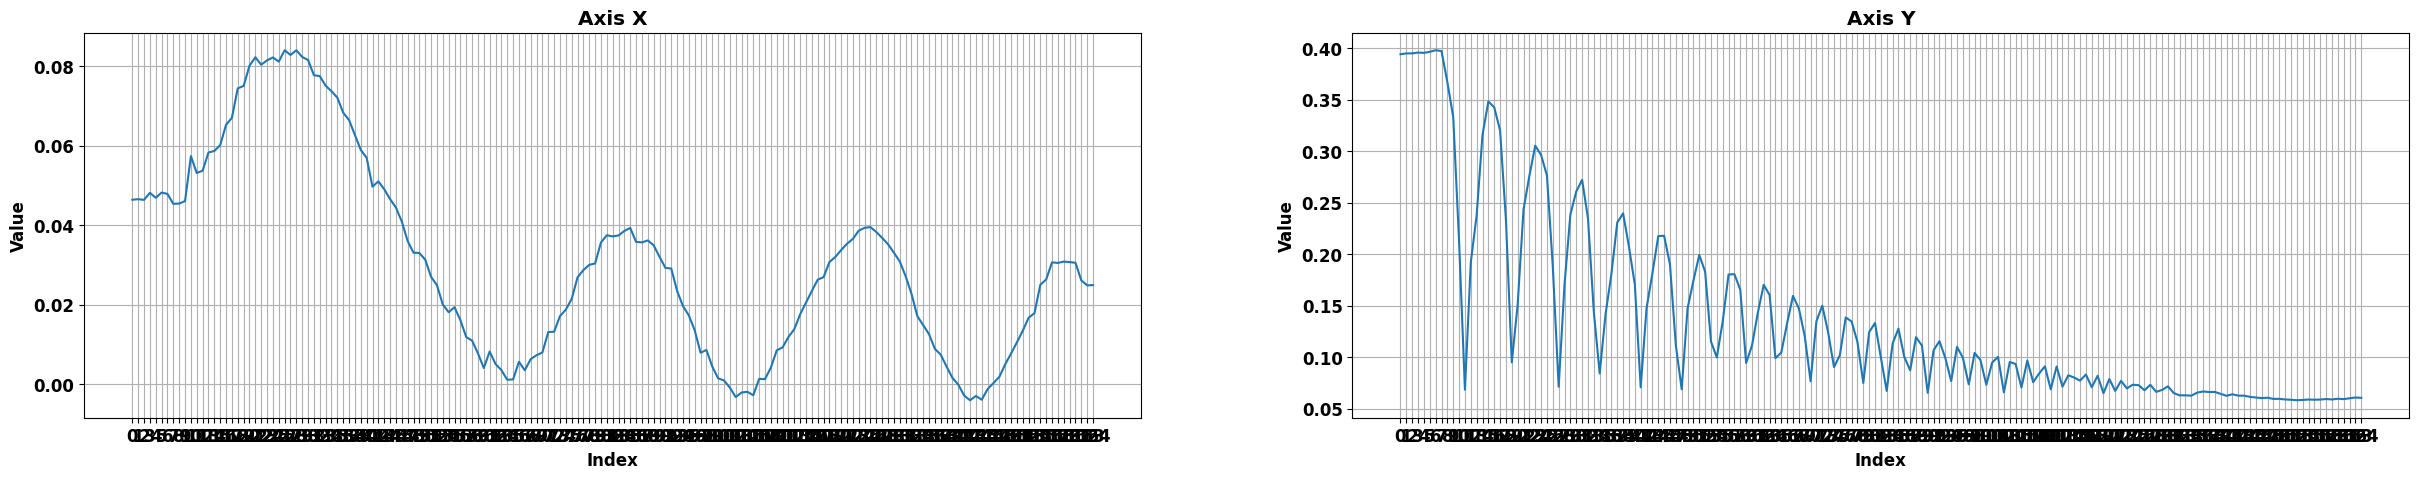

In [42]:
plotTrajectory(realTraj)

# Linear interpolation

In [9]:
# Interpolate real positions at the virtual timestamps using linear interpolation
def linear_interpolation(t, trajectory):
    times = [x[0] for x in trajectory]
    positions = [[x[1], x[2], x[3]] for x in trajectory]
    
    # Perform linear interpolation
    X = np.interp(t, times, np.array(positions)[:, 0])  # X component interpolation
    Y = np.interp(t, times, np.array(positions)[:, 1])  # Y component interpolation
    Z = np.interp(t, times, np.array(positions)[:, 2])  # Z component interpolation
    return X, Y, Z

In [10]:
# Now interpolate and compare positions
linVirtTraj = []
for rPoint in realTraj:
    real_time, real_pos = rPoint[0], [rPoint[1], rPoint[2], rPoint[3]]
    virtual_pos_interpolated = linear_interpolation(real_time, virtTraj)
    linVirtTraj.append([real_time, *virtual_pos_interpolated])
linVirtTraj = np.array(linVirtTraj)

In [11]:
assert linVirtTraj.shape == realTraj.shape

In [12]:
printErrors(realTraj, linVirtTraj)

L1 error: [0.         0.49796587 2.7596449  0.51268044]
MAE: [0.         0.01464606 0.08116603 0.01507884]
L2 error: [0.         0.01165372 0.44807737 0.01542277]
MSE: [0.         0.00034276 0.01317875 0.00045361]


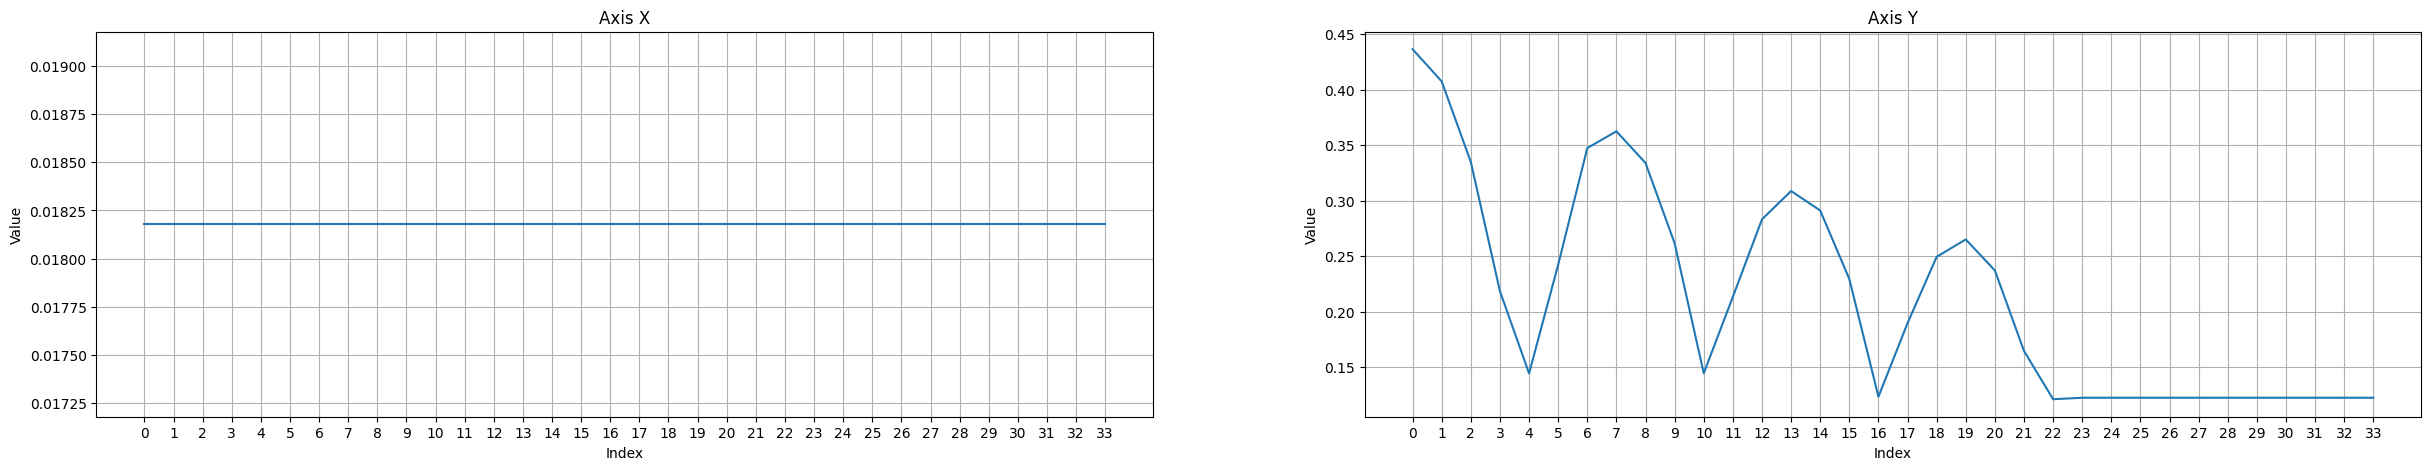

[0.         0.01817828 0.12117298 0.7589349 ] [2.308000e+03 1.817828e-02 4.363359e-01 7.639248e-01]


In [13]:
plotTrajectory(linVirtTraj)
print(np.min(linVirtTraj, axis=0), np.max(linVirtTraj, axis=0))

[ 0.         -0.01014763  0.1151926   0.7568154 ] [2.308000e+03 2.001463e-02 4.379292e-01 8.487954e-01]


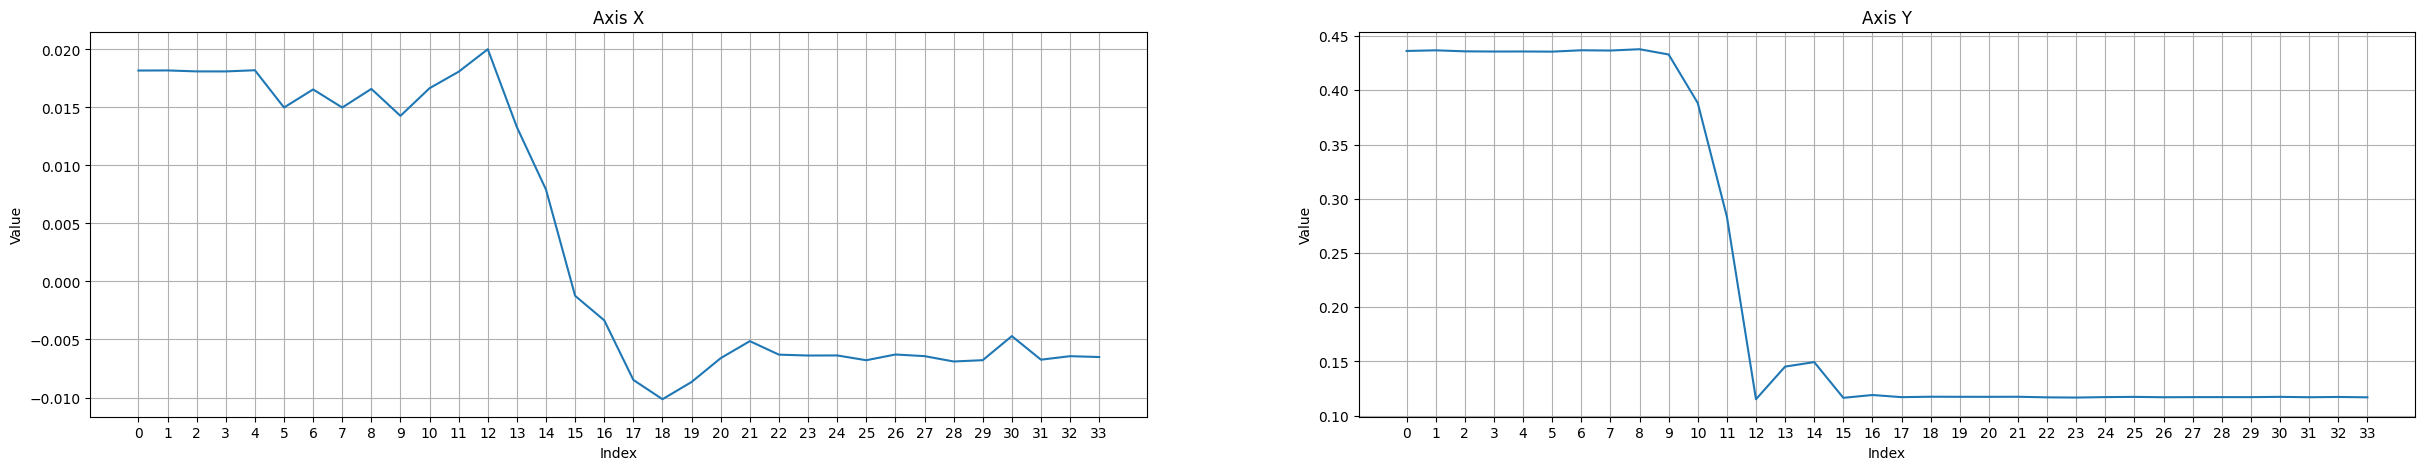

In [14]:
print(np.min(realTraj, axis=0), np.max(realTraj, axis=0))
plotTrajectory(realTraj)

# Plot drawing

In [126]:
def filter_static_points(trajectory, velocity_threshold=0.01):
    """
    Remove static points from a trajectory by filtering out data
    where the object is effectively static.

    Parameters:
        trajectory (numpy array): Nx4 array with columns [timestamp, x, y, z].
        velocity_threshold (float): Minimum velocity (Euclidean distance per second) to consider as moving.

    Returns:
        numpy array: Filtered trajectory with only valid (moving) points.
    """
    # Compute differences in positions and timestamps
    deltas = np.diff(trajectory[:, 1:], axis=0)  # Differences in x, y, z
    time_deltas = np.diff(trajectory[:, 0])  # Differences in timestamp

    # Compute velocities (Euclidean distance / time)
    velocities = np.linalg.norm(deltas, axis=1) / time_deltas

    # Mark points as valid where velocity > threshold
    valid_mask = velocities > velocity_threshold
    
    # Include the last valid point (marking it as static leads to removal)
    valid_mask = np.append(valid_mask, [False])
    
    # Filter trajectory using the mask
    return trajectory[valid_mask]


In [173]:
bounciness_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
n_iter = 1
ball_bounciness = 0.9
draw_plot = True
thresholds = { # Finetuned manually
    "ball1_hard": 0.0001,
    "ball1_soft": 0.00006,
    "ball2_hard": 0.0001,
    "ball2_soft": 0.0001
}

plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 12

total_errors = {}

case_dirs = ["ball1_hard", "ball1_soft", "ball2_hard", "ball2_soft"]

Before (165, 4)
After (114, 4)
------------
Before (34, 4)
After (9, 4)
------------
Before (146, 4)
After (32, 4)
------------
Before (46, 4)
After (12, 4)
------------


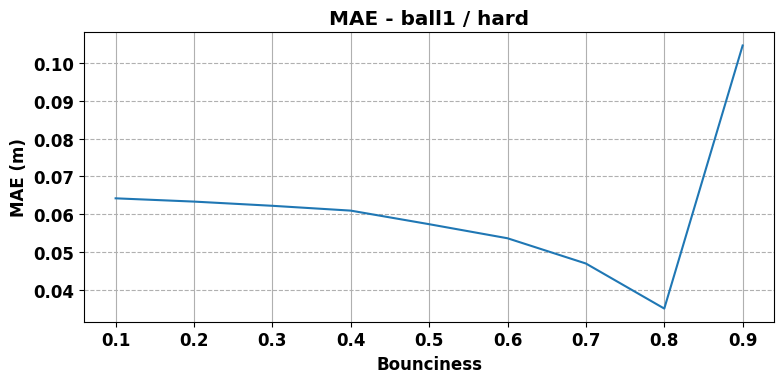

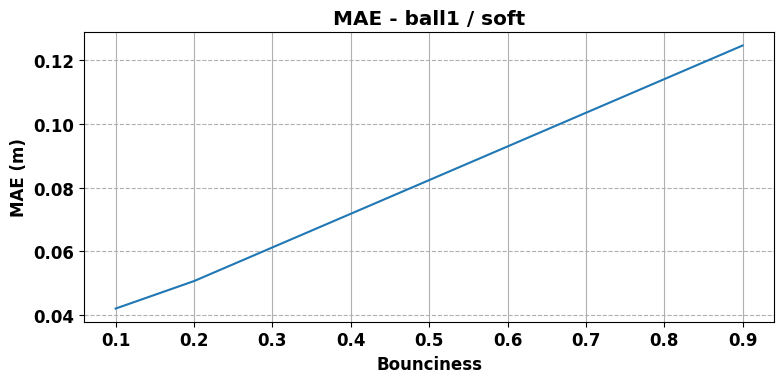

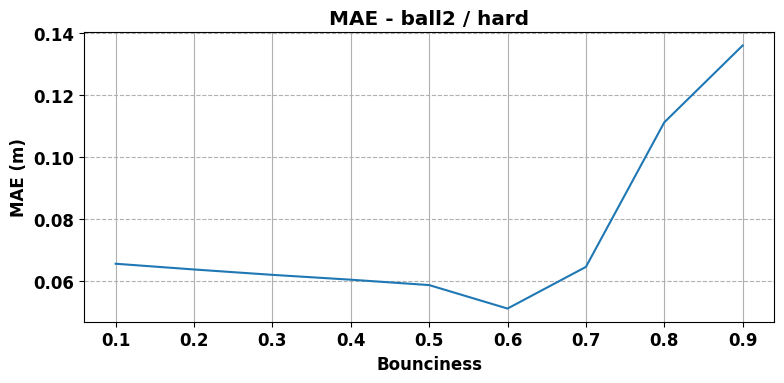

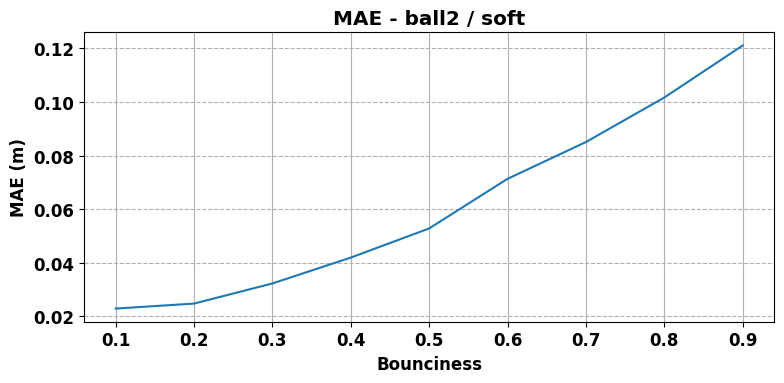

In [174]:
for base_dir in case_dirs:
    plot_name = base_dir.replace("_", " / ")
    errors = []
    if draw_plot:
        fig, axes = plt.subplots(3, 3, figsize=(18, 9))  # Create a 3x3 grid of subplots
        axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing


    realTraj = pd.read_csv(f"{base_dir}/{base_dir}_centroids_transformed.txt").to_numpy()
    realTraj[:, 0] -= realTraj[0, 0]
    print("Before", realTraj.shape)
    filteredRealTraj = filter_static_points(realTraj, thresholds[base_dir])
    print("After", filteredRealTraj.shape)
    print("------------")

    for i, b in enumerate(bounciness_range):
        fileName = f"{base_dir}_virtual_centroids_{ball_bounciness}_{b}_0.txt"
        filePath = os.path.join(base_dir, fileName)
        
        virtTraj = pd.read_csv(filePath).to_numpy()

        virtTraj[:, 0] -= virtTraj[0, 0]
        virtTraj[:, 0] *= 1000
        
        # Now interpolate and compare positions
        linVirtTraj = []
        for rPoint in realTraj:
            real_time, real_pos = rPoint[0], [rPoint[1], rPoint[2], rPoint[3]]
            virtual_pos_interpolated = linear_interpolation(real_time, virtTraj)
            linVirtTraj.append([real_time, *virtual_pos_interpolated])
        linVirtTraj = np.array(linVirtTraj)
        
        assert linVirtTraj.shape == realTraj.shape

        filteredVirtTraj = linVirtTraj # filter_static_points(linVirtTraj, 0.0)    
        
        maxIdx = filteredRealTraj.shape[0]
        
        # printErrors(realTraj[:maxIdx], filteredVirtTraj[:maxIdx])
        errors.append(calcMAE(filteredRealTraj[:maxIdx], filteredVirtTraj[:maxIdx])[2])
        
        if draw_plot:
            if i > 8: 
                continue
            # Plot each trajectory in the corresponding subplot
            axes[i].plot(linVirtTraj[:maxIdx, 2], label="Virtual Trajectory")
            axes[i].plot(filteredRealTraj[:maxIdx, 2], label="Real Trajectory")
            axes[i].set_title(f'Bounciness {b}')  # Title for the figure
            if i > 5:
                axes[i].set_xlabel('Frame Idx')  # X-axis label (assuming index is the x-axis)
            if i == 0 or i == 3 or i == 6:
                axes[i].set_ylabel('Traj')  # Y-axis label
            axes[i].grid(True)
            axes[i].legend()
        fig.suptitle(f"Trajectories - {plot_name}", fontsize=20, fontweight='bold')
    total_errors[base_dir] = errors
    # Save each plot as a separate PNG file
    output_path = f"{base_dir}-output_3x3.png" # f"output_plot_bounciness_{b}.png"  # Create a unique filename for each plot
    plt.tight_layout(h_pad=1.0) 
    # plt.show()
    plt.savefig(output_path, dpi=800, bbox_inches='tight')  # Save the figure
    plt.close(fig)  # Close the figure to avoid overlap between iterations
    
    plt.figure(figsize=(8, 4))
    plt.plot(bounciness_range, errors)
    plt.title(f"MAE - {plot_name}")
    plt.xlabel("Bounciness")
    plt.ylabel("MAE (m)")
    plt.xticks(bounciness_range)  # Set x-ticks to match the values in bounciness_range
    plt.grid(axis='x')  # Ensure grid lines are drawn for the x-axis
    plt.grid(axis='y', linestyle='--')  # Optionally add grid for y-axis with a different style
    plt.tight_layout() 
    plt.savefig(f"{base_dir}-error.png", dpi=300)


4 4


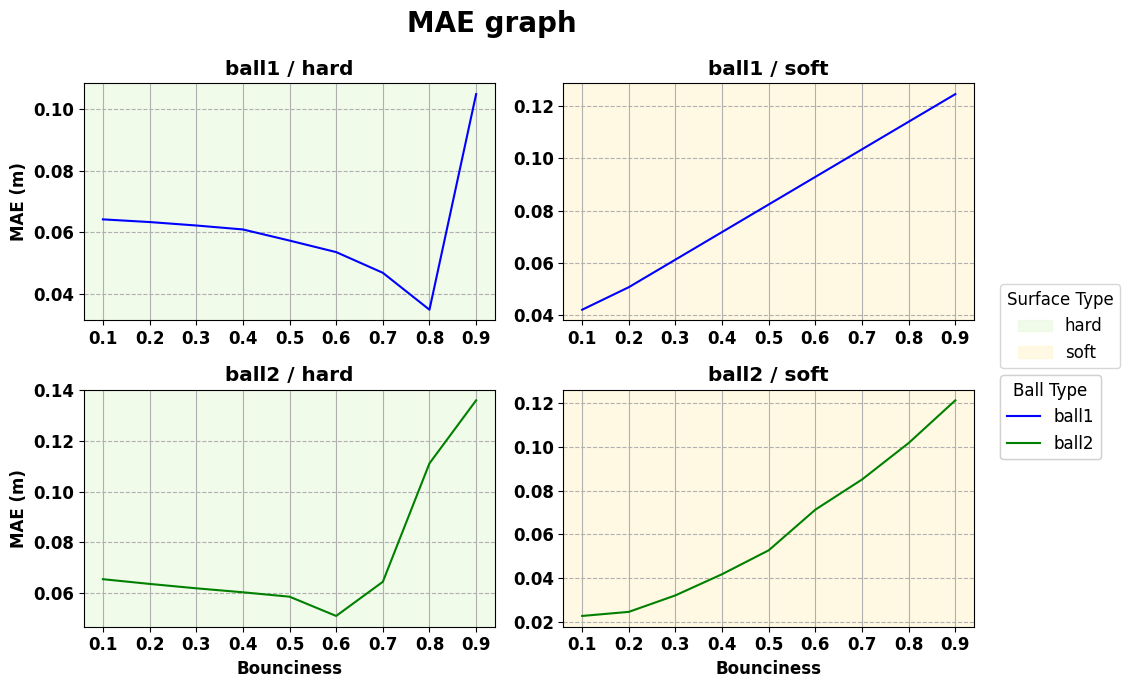

In [242]:
import matplotlib.patches as mpatches


fig, axes = plt.subplots(2, 2, figsize=(10, 7))  # Create a 2x2 grid of subplots
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing
print(len(axes), len(case_dirs))

# Create empty lists for plot legends
plot_legends = []
face_legends = []
s0, s1 = True, True
for i, base_dir in enumerate(case_dirs):
    plot_name = base_dir.replace("_", " / ")
    line_color = 'blue' if "ball1" in plot_name else 'green'
    
    # Plot the data and add a label for the line color in the legend
    axes[i].plot(bounciness_range, total_errors[base_dir], line_color, label=f"{base_dir.split('_')[0]}")

    axes[i].set_title(f"{plot_name}")
    if i >= 2:
        axes[i].set_xlabel("Bounciness")
    if i % 2 == 0:
        axes[i].set_ylabel("MAE (m)")
    axes[i].set_xticks(bounciness_range)  # Set x-ticks to match the values in bounciness_range
    axes[i].grid(axis='x')  # Ensure grid lines are drawn for the x-axis
    axes[i].grid(axis='y', linestyle='--')  # Optionally add grid for y-axis with a different style
    
    # Set face color and add legend for face color
    if i % 2 == 0:
        axes[i].set_facecolor('#E4F8D680')
        if s0:
            face_legends.append(mpatches.Patch(color='#E4F8D680', label=f"{base_dir.split('_')[1]}"))
            s0 = False
    else:
        axes[i].set_facecolor('#FFF7D3A0')
        if s1:
            face_legends.append(mpatches.Patch(color='#FFF7D3A0', label=f"{base_dir.split('_')[1]}"))
            s1 = False

# Title for the entire figure
fig.suptitle("MAE graph", fontsize=20, fontweight='bold')

plt.tight_layout() 
# Add the plot color legend and the face color legend
h0, l0 = axes[0].get_legend_handles_labels()  # Get handles and labels for the plot color legend
h1, l1 = axes[2].get_legend_handles_labels() 
handles = [h0[0], h1[0]]
labels = [l0[0], l1[0]]
legend_properties = {'weight':'normal'}
legendtitle_properties = {'weight':'normal'}
legend1 = fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1.0, 0.47), ncol=1, title="Ball Type", prop=legend_properties, title_fontproperties=legendtitle_properties)
fig.legend(face_legends, [patch.get_label() for patch in face_legends], loc='upper left', bbox_to_anchor=(1.0, 0.6), ncol=1, title="Surface Type", prop=legend_properties, title_fontproperties=legendtitle_properties)
fig.gca().add_artist(legend1)

# Layout and save figure

# plt.subplots_adjust(right=0.9) 
plt.savefig(f"total-error.png", dpi=300, bbox_inches='tight')
# plt.show()
